<a href="https://colab.research.google.com/github/umairiqbal78/Deep-learning-Projects/blob/main/poetry_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [15]:
# load in the data
input_texts = []
target_texts = []
for line in open('/content/drive/MyDrive/poetry/poetry.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [16]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [17]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [18]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [19]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [20]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/MyDrive/Glove_embedding/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [21]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [22]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [23]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [24]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...


In [25]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/2000
9/9 [==============================] - 2s 241ms/step - loss: 5.3626 - accuracy: 0.0708 - val_loss: 5.0282 - val_accuracy: 0.0833
Epoch 2/2000
9/9 [==============================] - 2s 200ms/step - loss: 4.6008 - accuracy: 0.0833 - val_loss: 4.8193 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 2s 195ms/step - loss: 4.3874 - accuracy: 0.0833 - val_loss: 4.9466 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 2s 204ms/step - loss: 4.3309 - accuracy: 0.0833 - val_loss: 4.9611 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 2s 196ms/step - loss: 4.2975 - accuracy: 0.0833 - val_loss: 4.9929 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 2s 193ms/step - loss: 4.2614 - accuracy: 0.0833 - val_loss: 4.9810 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 2s 193ms/step - loss: 4.2126 - accuracy: 0.0833 - val_loss: 4.9198 - val_accur

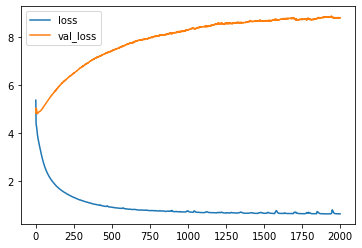

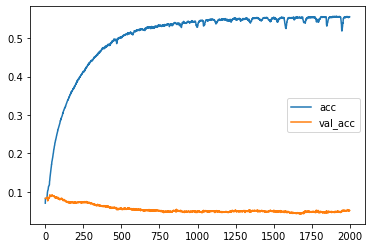

In [26]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [27]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


In [28]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [29]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [30]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

at least to pass by and either cloud or matter enough they
heaven gives it glimpses only to those
a hole in somewhere with his heel.
i was half boring through, half climbing through
---generate another? [Y/n]---y
i want to get out on the door
and the light breaking on them one traveler, long i could have
that now not all the difference.
was only adding frost to snow
---generate another? [Y/n]---y
and some exclaimed who saw afar
shatter it inward on the unswept floors.
(and i think for a time he snapped his eyes three times;
to send it sailing out the attic window
---generate another? [Y/n]---n


In [31]:
import pickle

modelStoragePath = "/content/drive/MyDrive/poetry"

def saveData(model, r , iteration):
    modelFile = modelStoragePath + "model_LSTM_poetry_generator" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_LSTM_poetry_generator" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving r  file too
    with open(rFile, 'wb') as file_pi:
        pickle.dump(r.history, file_pi)
    return modelFile, rFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "model_LSTM_poetry_generator" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_LSTM_poetry_generator" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(rFile, 'rb') as file_pi:
        r  = pickle.load(file_pi)
    return model,  r

In [32]:
print(type(r))
modelFile, rFile = saveData(model, r, iteration=1)
print(modelFile, rFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/MyDrive/poetrymodel_LSTM_poetry_generator1.h5 /content/drive/MyDrive/poetry_History_LSTM_poetry_generator1.pkle Saved
